# Exploratory analysis and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from scipy.signal import periodogram

In [2]:
# import dataset
zone = 'SARD'
PATH = f'data/wind_{zone}.csv'
data = pd.read_csv(PATH)

In [3]:
data

,Date,Energy
0,2015-01-03,597.7
1,2015-01-04,552.5
2,2015-01-05,197.7
3,2015-01-06,152.3
4,2015-01-07,91.9
...,...,...
2752,2022-10-18,22.0
2753,2022-10-22,130.8
2754,2022-10-23,118.9
2755,2022-10-24,90.0


In [4]:
# convert date to format datetime
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [5]:
# complete all the datetimes
all_datetimes = pd.DataFrame(pd.date_range(datetime(df['Date'].min().year, 1, 1), df['Date'].max(), freq='d'), columns=['Date'])
df = all_datetimes.merge(df, on=['Date'], how='outer')
df.set_index('Date', inplace=True)
df

,Energy
Date,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,597.7
2015-01-04,552.5
2015-01-05,197.7
...,...
2022-10-22,130.8
2022-10-23,118.9
2022-10-24,90.0


In [6]:
# fill the missing values with the closest available data
df['Energy'] = df['Energy'].fillna(method='ffill').fillna(method='bfill')

In [7]:
# check if every year has 365 data points (except the last year)
df = df.reset_index(drop=False)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df.set_index('Date', inplace=True)

count_year_df = df.groupby('Year')['Energy'].count()
count_year_df

Year
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    299
Name: Energy, dtype: int64

In [8]:
# use only complete years
condition = count_year_df >= 365
complete_years = count_year_df.loc[condition].index
df = df.loc[df['Year'].isin(complete_years)]
df

,Energy,Year
Date,,
2015-01-01,597.7,2015
2015-01-02,597.7,2015
2015-01-03,597.7,2015
2015-01-04,552.5,2015
2015-01-05,197.7,2015
...,...,...
2021-12-27,371.7,2021
2021-12-28,521.2,2021
2021-12-29,715.9,2021


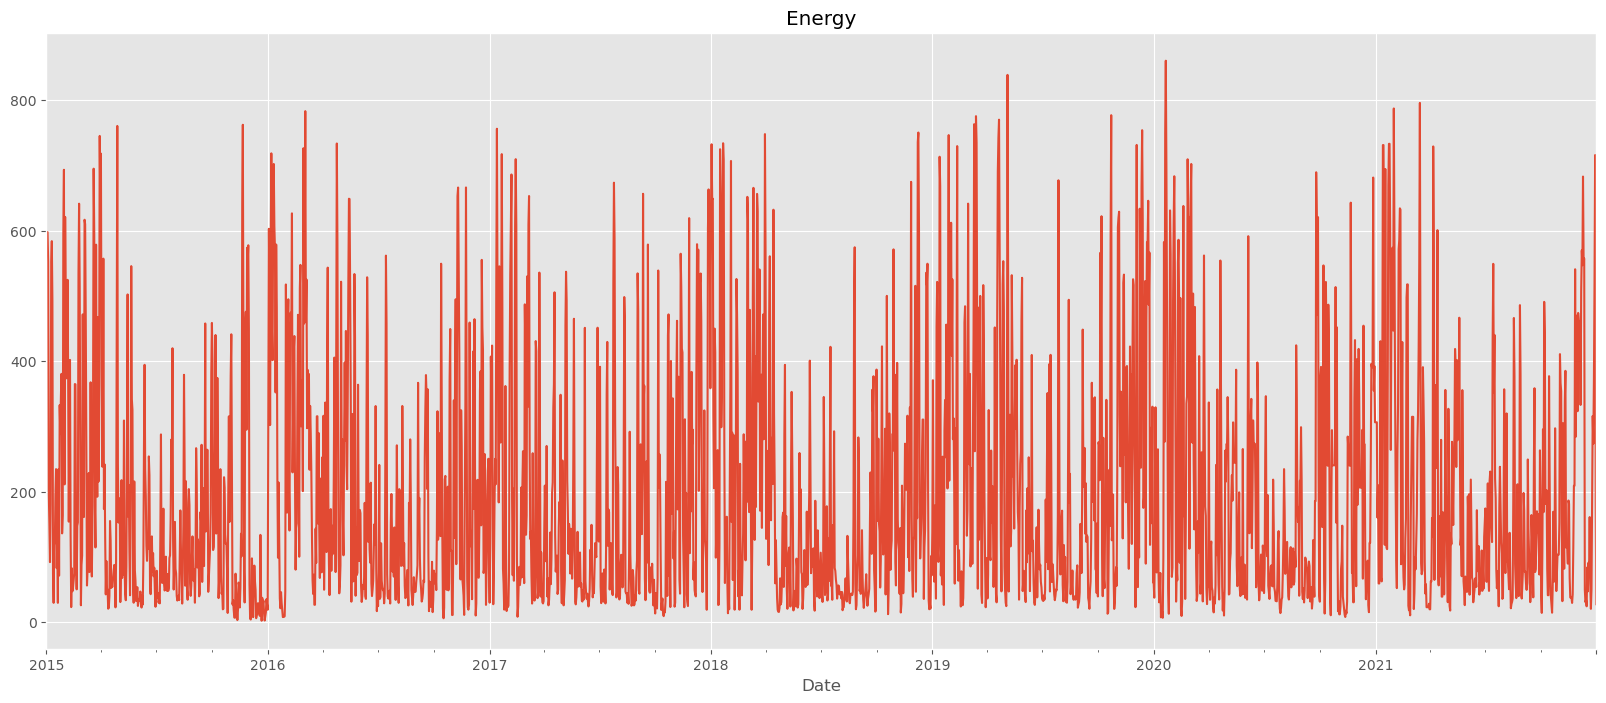

In [9]:
df['Energy'].plot(figsize=(20,8))
plt.title('Energy')
plt.show()

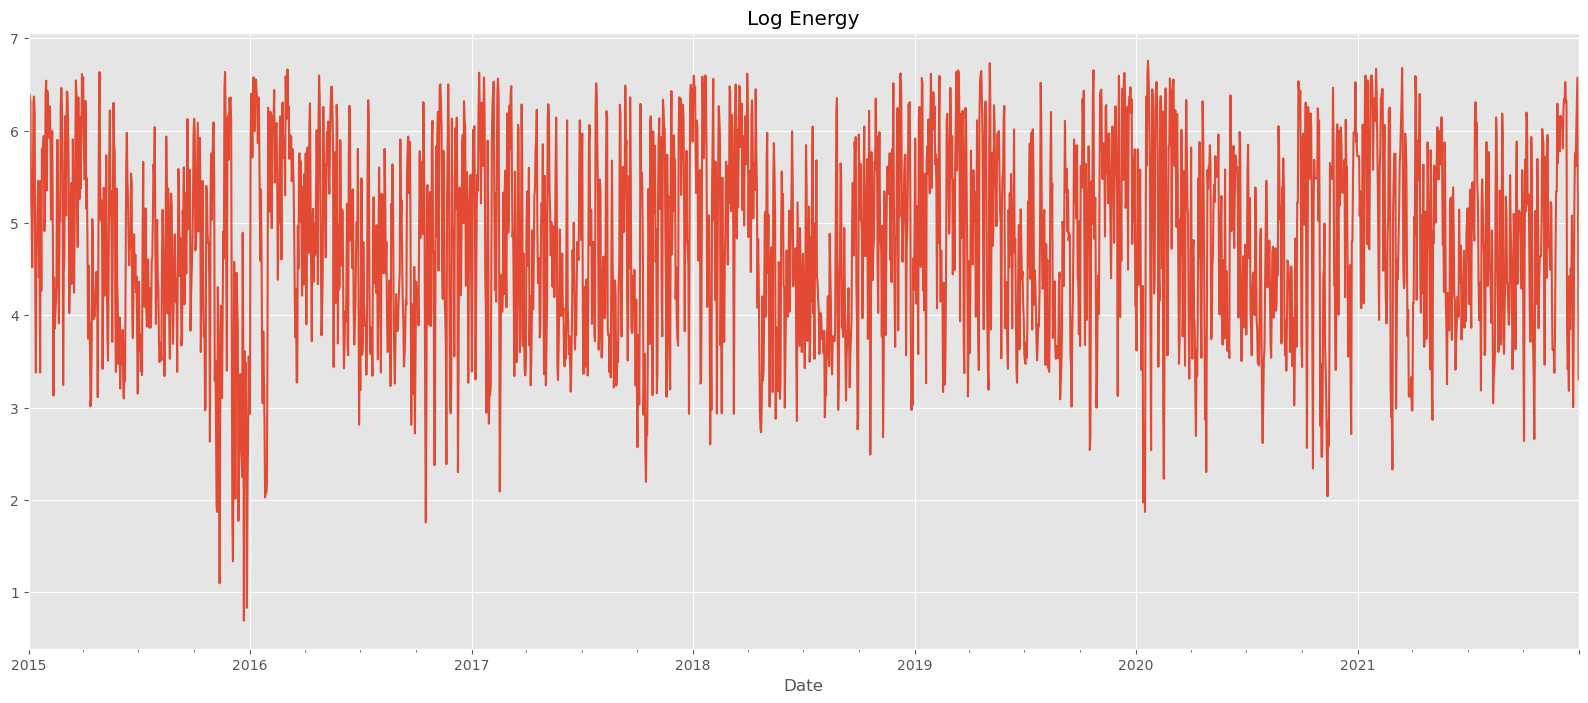

In [10]:
np.log(df['Energy']).plot(figsize=(20,8))
plt.title('Log Energy')
plt.show()

# Time series decomposition

### Orginal series

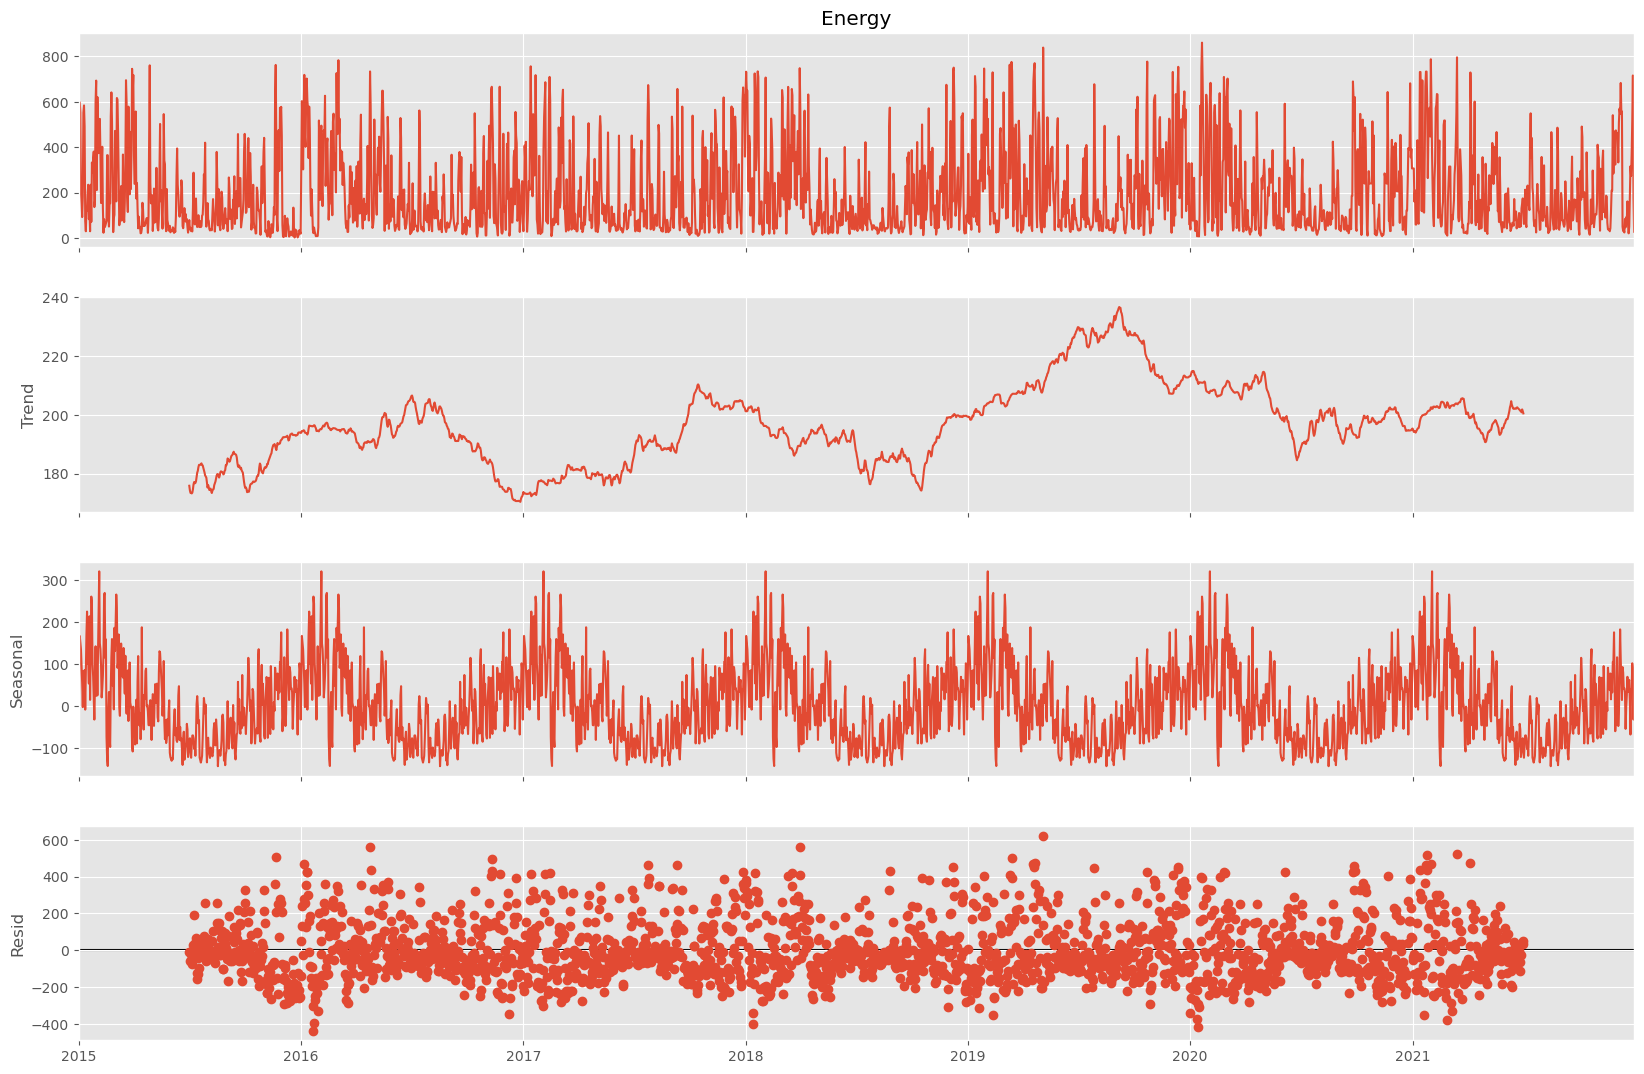

In [11]:
# additive
res = seasonal_decompose(df['Energy'], model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

In [20]:
#idx = df.loc[df['Energy'] <= 0].index
#df.loc['2015-11-12', 'Energy'] = (df.loc['2015-11-11', 'Energy'] + df.loc['2015-11-13', 'Energy']) / 2

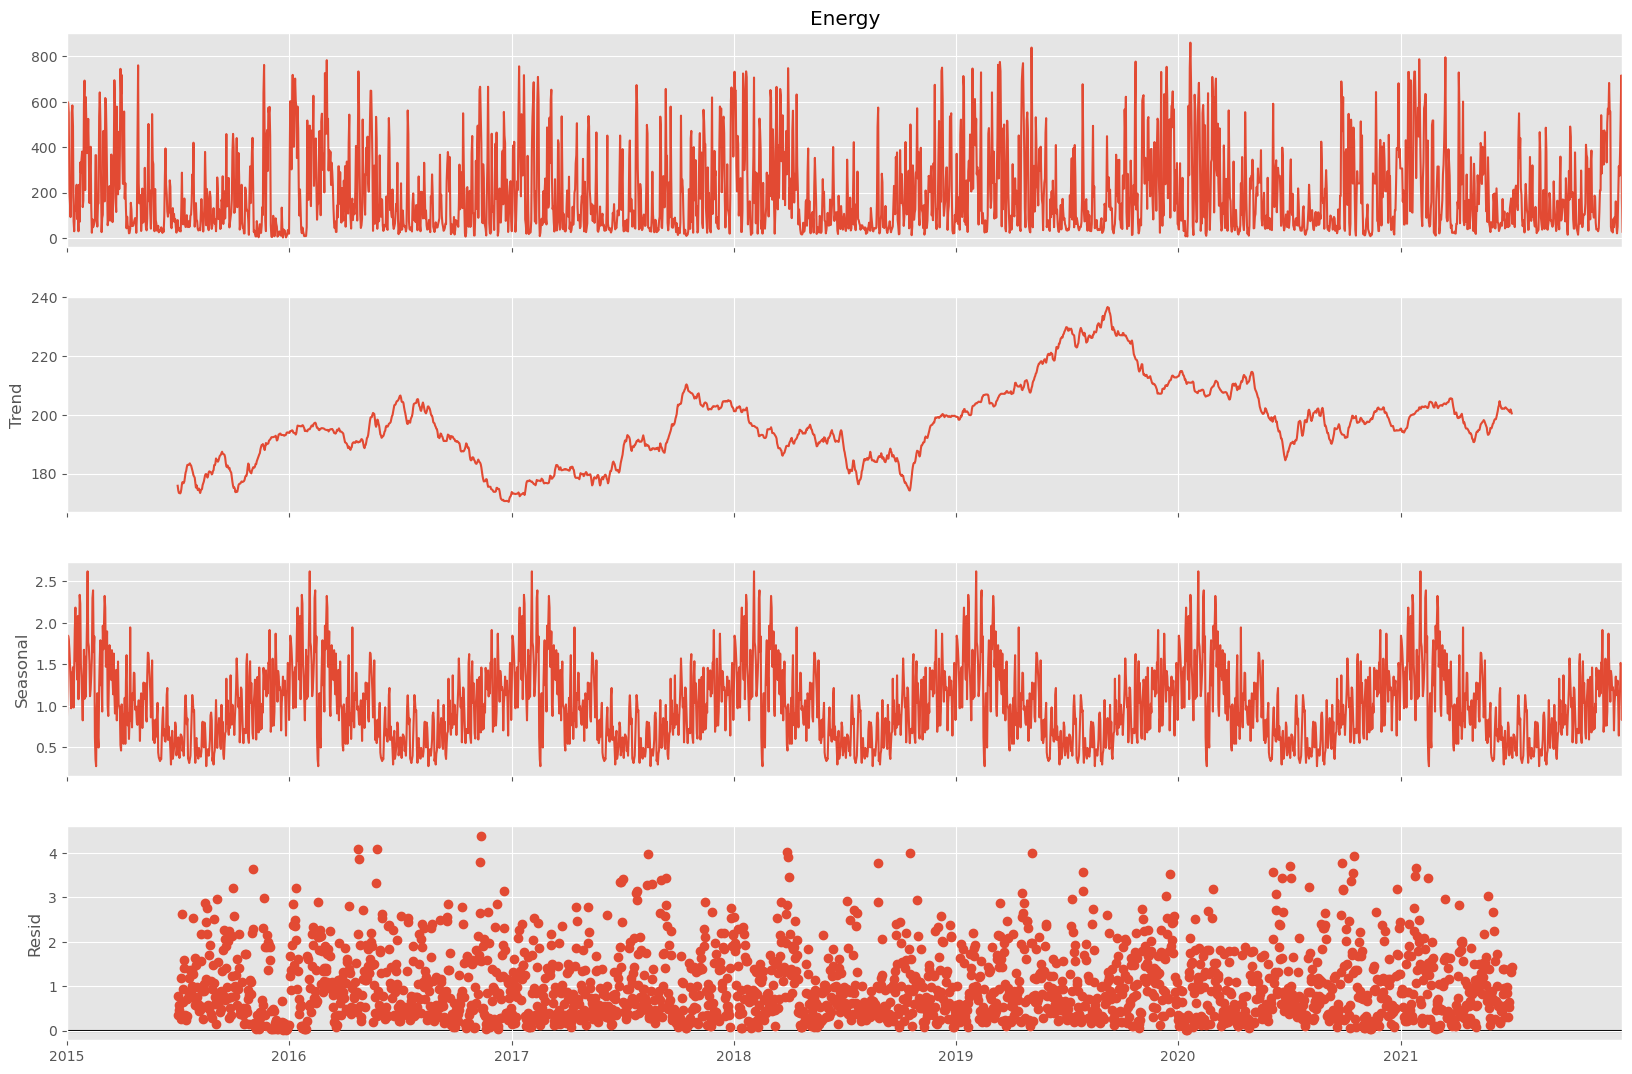

In [12]:
# multiplicative
res = seasonal_decompose(df['Energy'], model='multiplicative', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

### Log series

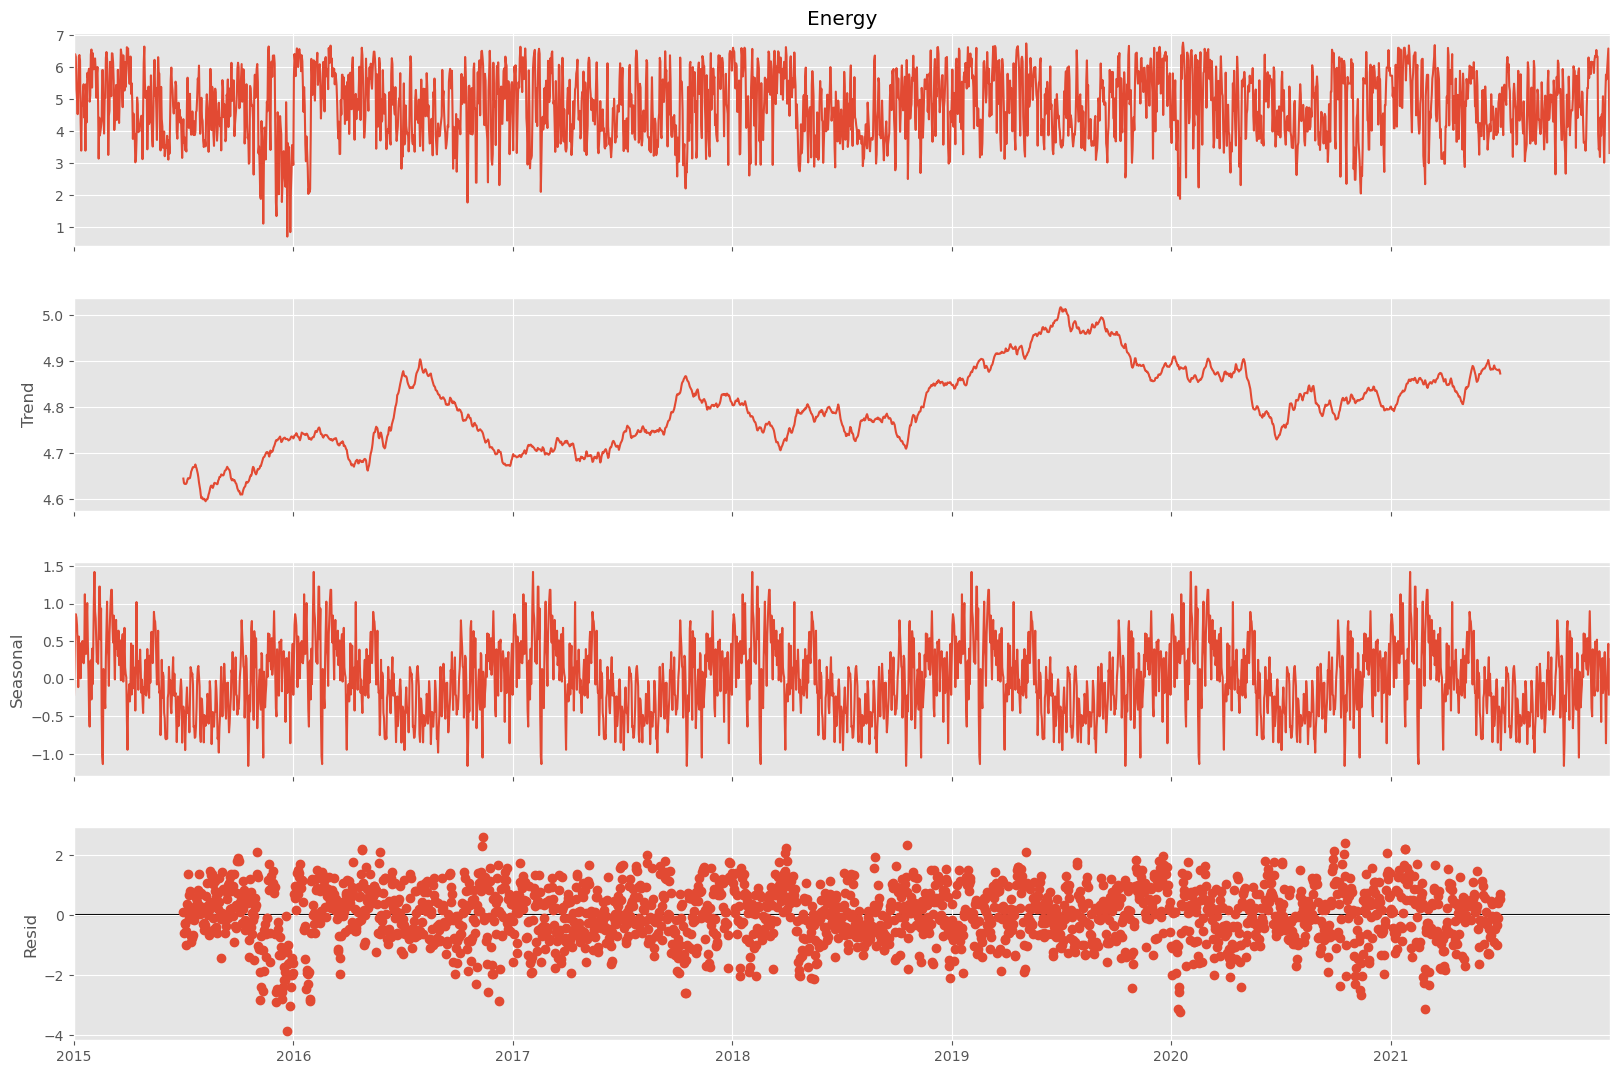

In [13]:
dflog = np.log(df.loc[df['Year'] < 2022, 'Energy'])

res = seasonal_decompose(dflog, model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

## Trend isolation

We use the log series, with additive decomposition. Let us smooth the trend component.

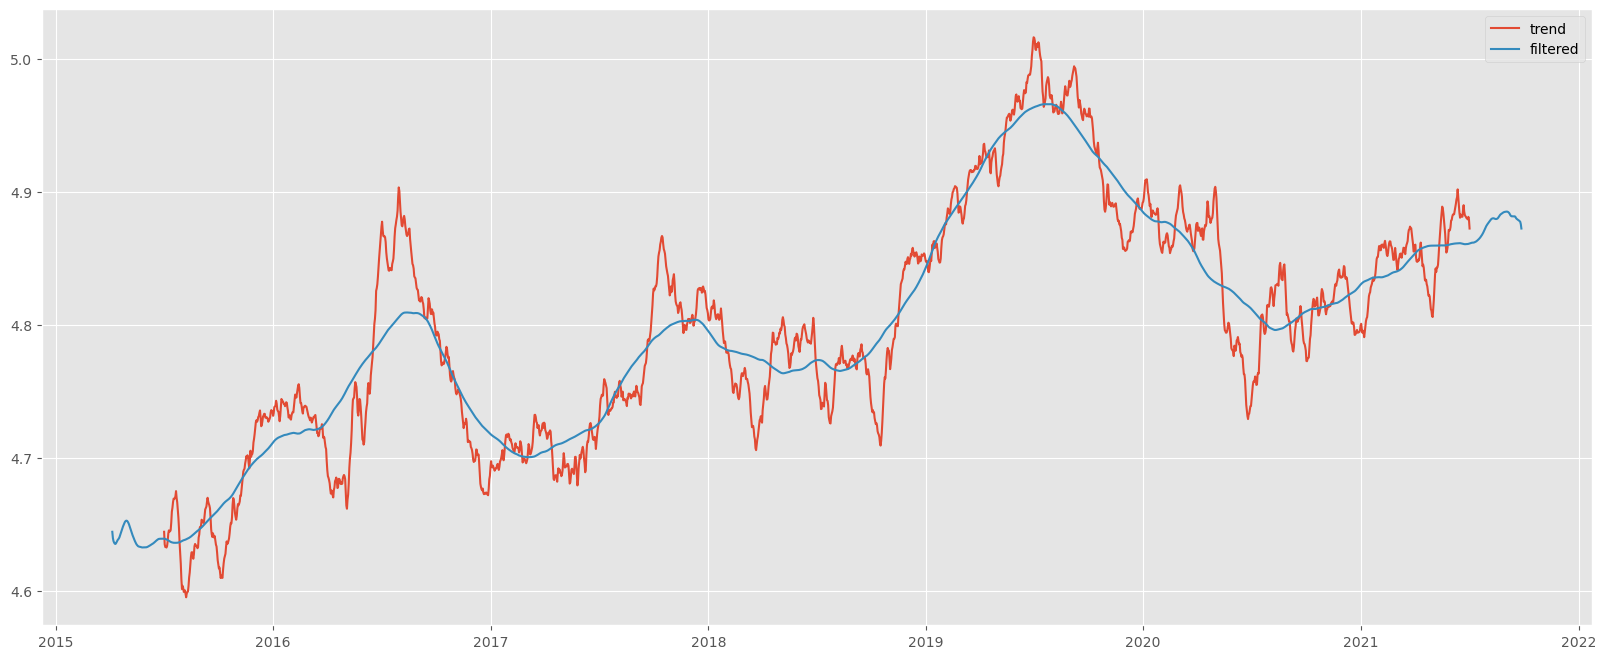

In [14]:
# smooth the trend
x_smooth = res.trend.rolling(175, min_periods=1, center=True).mean()

plt.figure(figsize=(20,8))
plt.plot(res.trend, label='trend')
plt.plot(x_smooth, label='filtered')
plt.legend()
plt.show()

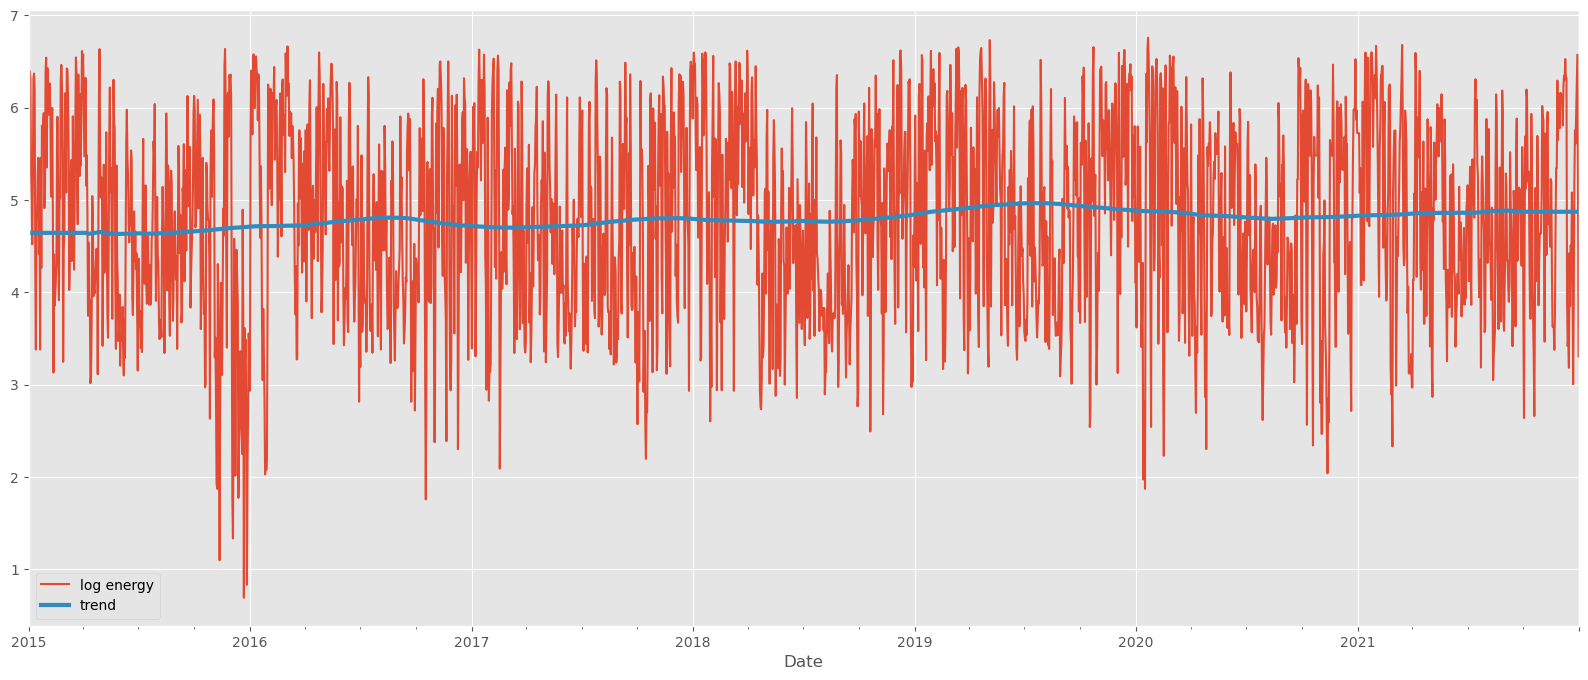

In [15]:
# recover missing data by forward and backward fill
trend = x_smooth
trend = trend.fillna(method='ffill').fillna(method='bfill')

plt.figure(figsize=(20,8))
dflog.plot(label='log energy')
trend.plot(label='trend', linewidth=3)
plt.legend()
plt.show()

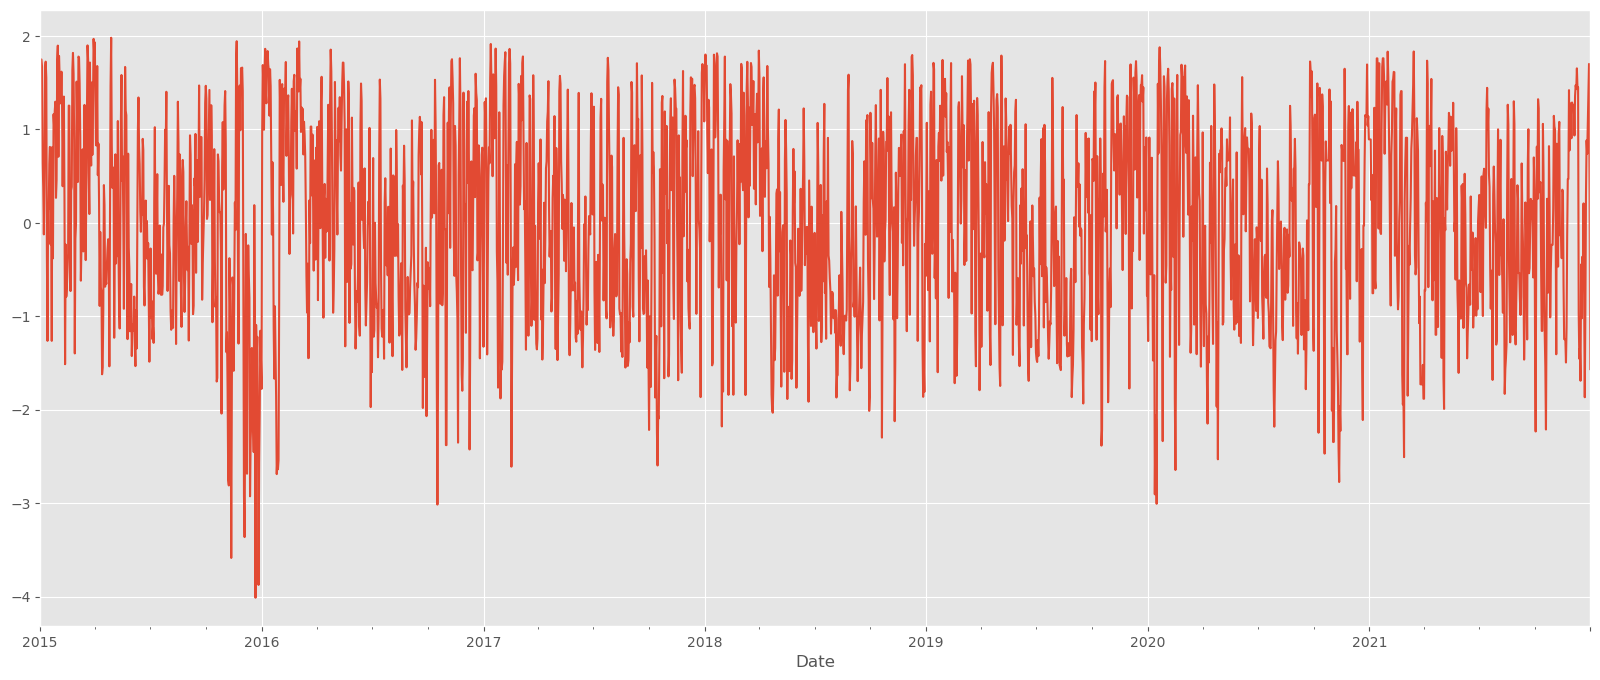

In [16]:
# obtain the detrended series
detrended = dflog - trend
detrended.plot(figsize=(20,8))
plt.show()

## Seasonality isolation

We perform frequency analysis with periodogram.

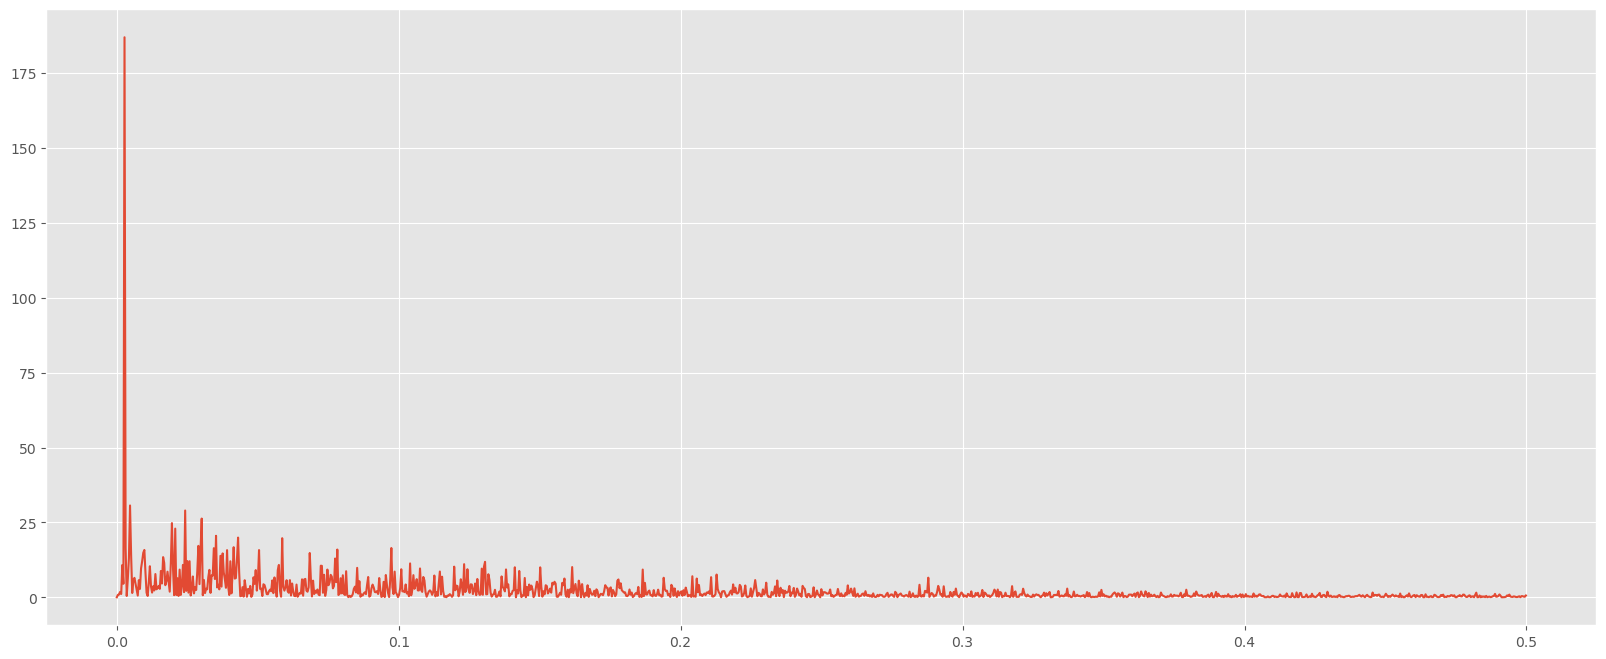

365


In [17]:
# plot periodogram
f, Pxx_den = periodogram(detrended)
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

# get the highest frequency
freq = f[Pxx_den > 120]

# which correspond to a certain period
T = int(1/freq)
print(T)

The greatest periodicty is 365 days, as we should have expected.
Now, let remove this periodicity.

In [18]:
# deseasonalize the series
def deseasonalize_fourier(series, period=365):
    """
    Deseasonalize a time series using Fourier decomposition.

    Parameters
    ----------
    series : pandas.Series
        A pandas Series containing the time series data.
    period : int, optional
        The period of the seasonality to be removed. Default is 365.

    Returns
    -------
    pandas.Series
        A pandas Series containing the deseasonalized time series.

    Notes
    -----
    The function performs a Fourier transform to decompose the time series,
    removes the seasonal components, and then applies an inverse Fourier
    transform to reconstruct the deseasonalized time series.
    """
    
    # Perform Fourier Transform
    fft_result = np.fft.rfft(series)
    frequencies = np.fft.rfftfreq(len(series), d=1)

    # Identify frequencies corresponding to the seasonality and set them to zero
    seasonal_freq = 1 / period
    fft_result[np.abs(frequencies - seasonal_freq) < 1e-3] = 0

    # Perform Inverse Fourier Transform
    deseasonalized = np.fft.irfft(fft_result, n=len(series))

    return pd.Series(deseasonalized, index=series.index)

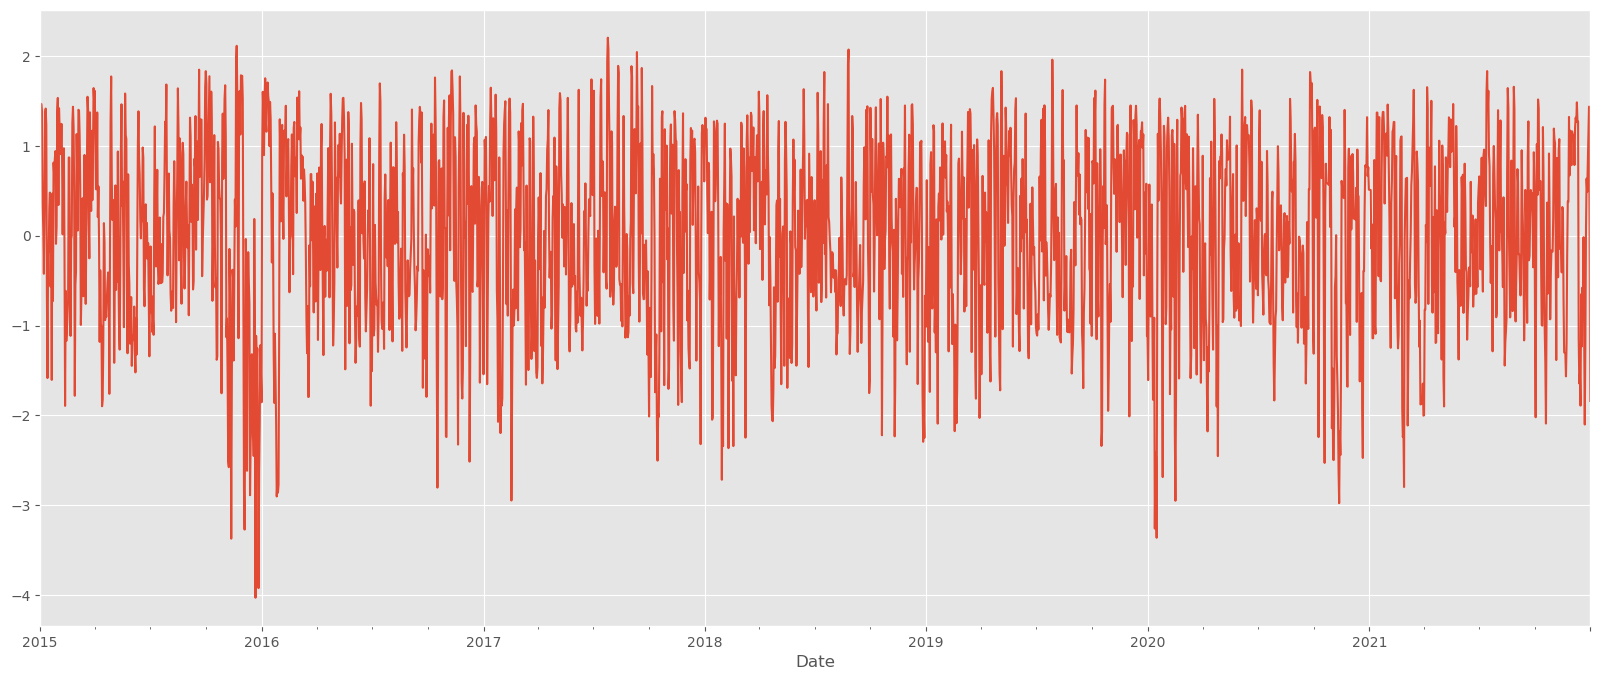

In [19]:
deseasonalized_series = deseasonalize_fourier(detrended, period=T)
deseasonalized_series.plot(figsize=(20,8))
plt.show()

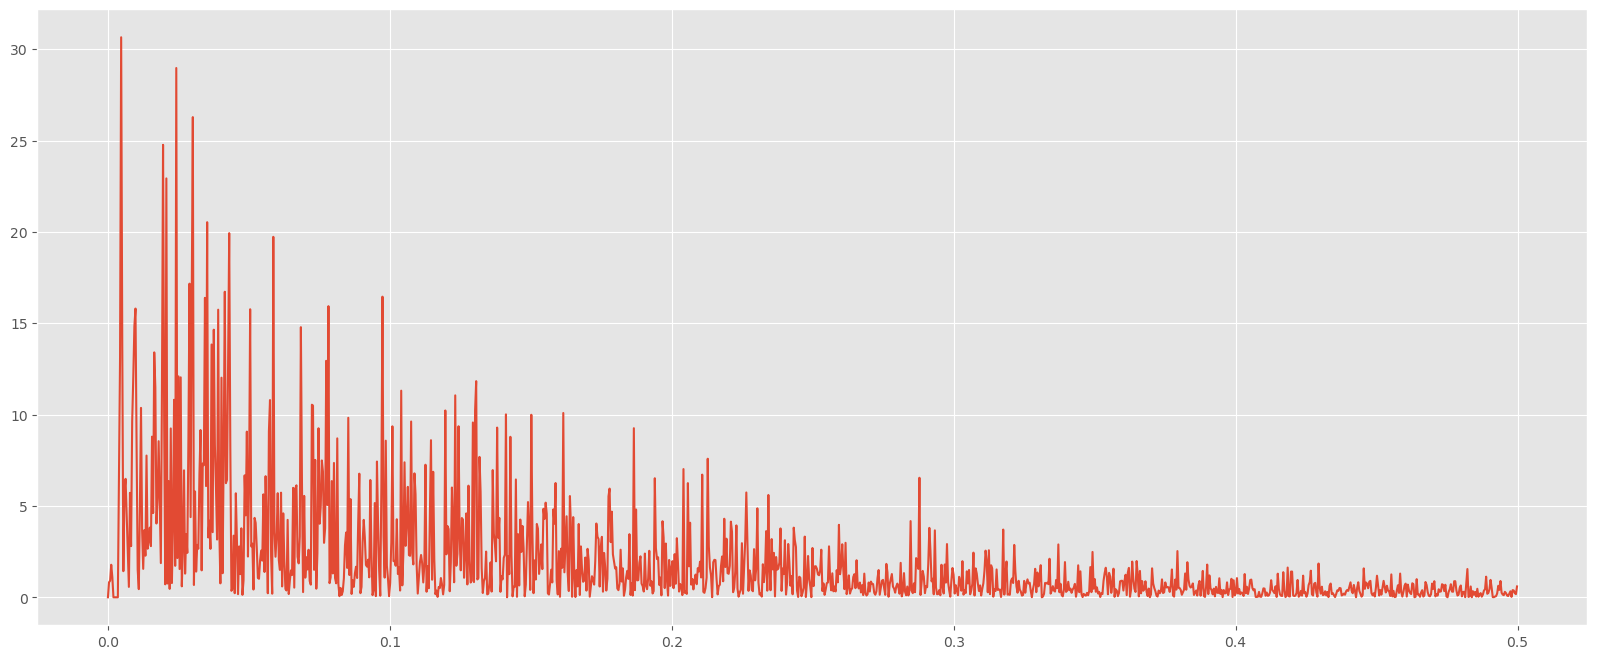

[213, 51, 48, 41, 33, 28]


In [20]:
# check for other periodicities

# plot periodogram
f, Pxx_den = periodogram(deseasonalized_series)
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

# get the highest frequency
freq = f[Pxx_den > 20]

# which correspond to a certain period
T = [int(x) for x in 1/freq]
print(T)

No more relevant periodicities

------

## Test for stationarity

### Augmented Dickey-Fuller (ADF) Test

we reject the null hypothesis of non-stationarity if the p-value is less than 0.05

In [21]:
from statsmodels.tsa.stattools import adfuller

residual_series = deseasonalized_series

result = adfuller(residual_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -21.829334261615962
p-value: 0.0


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
It has the opposite null hypothesis of the ADF test. The null hypothesis is that the time series is stationary around a deterministic trend. If the p-value is greater than the significance level, you fail to reject the null hypothesis.
If the p-value is greater than 0.05, you may fail to reject the null hypothesis.

In [22]:
from statsmodels.tsa.stattools import kpss

result = kpss(residual_series)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

KPSS Statistic: 0.03059471353130383
p-value: 0.1


/var/folders/0j/6dcms_yx1kxf_7qchx7x4vf40000gn/T/ipykernel_80755/1471600673.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(residual_series)


------

## Exporting residuals

In [23]:
residual_series.rename('energy', inplace=True)

Date
2015-01-01    1.471048
2015-01-02    1.467058
2015-01-03    1.463133
2015-01-04    1.380637
2015-01-05    0.349140
                ...   
2021-12-27    0.788661
2021-12-28    1.122408
2021-12-29    1.435576
2021-12-30    0.036828
2021-12-31   -1.839372
Name: energy, Length: 2557, dtype: float64

In [24]:
residual_series.to_csv(f'./data/res_{zone}.csv')

________

## Summary

To recap, the following preprocessing steps have been performed:

* logarithm
* trend isolation
* seasonality isolation

We are left with a stationary time series.

In mathematical terms, let $(Y_t)_t$ be the initial time series.
Now let $(X_t)_t$, where $X_t = \log(Y_t)$.
Time series decomposition leads to 
$$X_t = T_t + S_t + R_t.$$

When we predict new values of the stationary component, say $R_{t+1}$, in order to recover $Y_{t+1}$ we have to revers all the previous steps, i.e. 

* obtain a forecast of the trend: $T_{t+1}$
* obtain a forecast of the seasonal part: $S_{t+1}$; one possibility could be $S_{t+1} = S_{t-T}$, where $T = 365$.
* recover $X_{t+1} = T_{t+1} + S_{t+1} + R_{t+1}$
* finally, $Y_{t+1} = \exp(X_{t+1})$